<a href="https://colab.research.google.com/github/ChampInMyThought/One-ID/blob/main/OneID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📌 Project Plan: ONEID, Eclaim, OPPP Analysis

---

### 🔎 Further Exploratory Goals

- **Subfund Analysis**: Explore how `subfund` relates to visit types, frequency, and utilization.
- **Year-on-Year Comparison**: Compare January visits across years to detect behavioral trends.
- **Hospital & Regional Utilization**: Predict trends in utilization differences at hospital-level and regional-level.
- **Diagnosis ↔ Claim Link**: Investigate relationship between `pdx` and `act_amt` in Eclaim.
- cross visitซ Visit Patterns 🆗
    - % of cross-area visits (`hmain ≠ hcode`)
    - % of cross-province visits (`prov1 ≠ prov2`)

---

## ✅ DATA PREPARATION & FILTERING

### Filter Base Population 🆗
- `person_type = 1`
- Exclude discharges

### Match Facilities 🆗
- Compare `hmain` and `hcode`:
  - If `hmain == hcode`: **In-area visit**
  - If different, check if same รพช (district hospital) using hos map
- Use `prov1` (hcode) and `prov2` (hmain) to detect cross-province visits

---

## 🔗 DATA LINKING  *** ลองเช็คอีกที

- **Link Eclaim & OPPP**:
  - Match via `tran_id` only (ensure consistent IDs)
- **Link Visit to Claims**:
  - Join OPPP with Eclaim on `tran_id + subfund`
  - Filter for actual financial claims (`act_amt > 0`)
- **Group Items Under 1 Visit**:
  - Aggregate item codes by `tran_id`
  - Count number of claim items per visit

---

## 📊 DESCRIPTIVE ANALYSIS 🆗

### Summary Statistics
- Visit counts by:
  - `subfund`, `hmain`, `hcode`, `prov1`, `prov2`
  - `sex` (1 = male, 2 = female), `age`, province, hospital level
- Financial:
  - `total_amt` (submitted) vs `act_amt` (approved)

---

## 📈 TRENDS & ANALYTICS

### Year-on-Year Comparison
- Compare monthly visits (e.g., Jan '65 vs Jan '66 vs Jan '67)
- Track claim amount trends over time

### Interrupted Time Series
- Identify policy change dates
- Regression pre/post intervention
- Compare trend slopes

### Delay Effects
- Lagged analysis: Policy effects 1–3 months post change
- Segment by hospital level

---

## 🤖 MODELING (optional)

### Predict Cross-Area Visit
- Classification model:
  - Target: Is this a cross-area visit?
  - Features: Age, sex, hmain, hcode, province, hospital level

### Predict Claim Success
- Predict if `act_amt > 0`
- Use subfund + facility attributes as features

---


# Load Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [ ]:
file_path = "/content/drive/MyDrive/OneID/tri/zone_4/v_t_f_opd_indiv_flat_y67_202504271138.csv"

with open(file_path, 'r') as f:
    row_count = sum(1 for line in f)

print(f"Total data rows: {row_count}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/OneID/tri/zone_4/v_t_f_opd_indiv_flat_y67_202504271138.csv'

In [ ]:
chunksize = 100000
filtered_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    # Convert date_serv to string to filter by date prefix
    chunk['date_serv'] = chunk['date_serv'].astype(str)

    # Filter for first week of Jan 2023 (20230101 to 20230107)
    period = chunk[chunk['date_serv'].between("20240101", "20240331")]

    filtered_chunks.append(period)

# Combine all filtered chunks into a single DataFrame
df = pd.concat(filtered_chunks, ignore_index=True)


del filtered_chunks
del chunk
del period
gc.collect()

# Show sample
print(df.head())
print(f"Total rows loaded: {len(df)}")

# ลอง pickle


  date_serv  date_serv_str    month  \
0  20240316       20240316  2024-03   
1  20240304       20240304  2024-03   
2  20240104       20240104  2024-01   
3  20240201       20240201  2024-02   
4  20240103       20240103  2024-01   

                                             tran_id  \
0  87c557e7066433e22e52ec3b03fb5bc869061b25c1d58d...   
1  adb7696736f6faf3a7afa0d369752bcd424fbbffbbd7ad...   
2  c271481957a64c0a9923e481d41c57781fb3850bb5ce71...   
3  8747ec3f606301b8952ce0ed6632e8fe2536b37100b691...   
4  87c009f42e364cd7d3c823331206f3774d9627fa443a26...   

                                                 pid  \
0  15f5424e73472bea98a38260502803d97d2cf74407c055...   
1  3a67b3fed7bd263c8c1f17d56eb6aaf50c96668d2e9992...   
2  f94b664a2f3d6e697f2c41ff52b975f1960a767cb93716...   
3  64c24cf65fb5f070e680620a96ac977e3e564e1015ada1...   
4  8e2ed1b2e711f990965aae6c1816e18c96ce8a2e3bd8ab...   

                                                  hn  sex  age_year  hcode  \
0  e5b91aa60d

In [ ]:
df

# df['hosp_id'] = df['hosp_id'].apply(lambda x: f'{x:05}') # Format to 5 digits

,date_serv,date_serv_str,month,tran_id,pid,hn,sex,age_year,hcode,hmain,hsub,prov1,prov2,maininscl,pdx
0,20240316,20240316,2024-03,87c557e7066433e22e52ec3b03fb5bc869061b25c1d58d...,15f5424e73472bea98a38260502803d97d2cf74407c055...,e5b91aa60d7356b7520af7e294539af29de10f752879ad...,1,60.0,1091,11269,07829,1300,6700,WEL,Z718
1,20240304,20240304,2024-03,adb7696736f6faf3a7afa0d369752bcd424fbbffbbd7ad...,3a67b3fed7bd263c8c1f17d56eb6aaf50c96668d2e9992...,a7304eb5823534f1ec2b56eaf4e50fe1d476ac23358b69...,2,71.0,10791,10791,10791,1600,1600,WEL,L892
2,20240104,20240104,2024-01,c271481957a64c0a9923e481d41c57781fb3850bb5ce71...,f94b664a2f3d6e697f2c41ff52b975f1960a767cb93716...,d500f076232a546e2d4d961be603689278fa7afcaf49ee...,1,64.0,10795,10795,01545,1600,1600,WEL,F09
3,20240201,20240201,2024-02,8747ec3f606301b8952ce0ed6632e8fe2536b37100b691...,64c24cf65fb5f070e680620a96ac977e3e564e1015ada1...,b8825aec859ccae0f270cb6fada071fb7cca59c3245b26...,2,63.0,13815,13815,11168,1200,1200,WEL,E789
4,20240103,20240103,2024-01,87c009f42e364cd7d3c823331206f3774d9627fa443a26...,8e2ed1b2e711f990965aae6c1816e18c96ce8a2e3bd8ab...,6eb6db7a35b04fd8b3329deb643905b8e35bf1947f0e90...,2,77.0,1082,10687,01082,1300,1300,WEL,J00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3477865,20240111,20240111,2024-01,8bff855ddeba702716c5d148687ca0475d79b8c59066ff...,cab1fdad27d7e9d91f7318114ddc30111e933751bf7672...,36fee7f1d1deb74e3000af244210c304e4538596fe315f...,2,62.0,10660,10660,01156,1400,1400,WEL,R42
3477866,20240213,20240213,2024-02,1635e2e3befe3a6864ee39f00979f3e84b915240d1b534...,5e76c8be9f77f72d77d685e9c68cd789a514ab6e31ec4f...,98ddd9b237dc4ad7fb909631836938c3c3b86e19085a4e...,1,83.0,10791,10791,15269,1600,1600,WEL,E119
3477867,20240221,20240221,2024-02,745f69d40d4574422c7dae02ff1da4dc06b01b00ad64f7...,59214e3c38967ca199e678fab896344da4f7554403fa7d...,a9ab128c0d6156a224c74abb10aad2d104eeb0af6ff983...,1,61.0,31157,10767,31157,1300,1300,WEL,J029
3477868,20240325,20240325,2024-03,3b2b999202aa21b478ad3d7f39de4442e7f8e7906ae0bb...,4f422d77e9160d4f13934019ea2621749d84904c80a274...,ec0c4dd6e7206885acb739b7c488c587f9319092712884...,2,77.0,13815,13815,22424,1200,1200,WEL,NaN


# Analysis

In [ ]:
# Calculate summary statistics for numerical columns in the dataframe
# Exclude columns with datetime data type
numerical_cols = df.select_dtypes(include=['number', 'bool']).columns
summary_stats = df[numerical_cols].describe()

# Display the summary statistics
print("Summary Statistics:")
print(summary_stats)

# For more detailed statistics, including skewness, kurtosis, and missing values
print("\nAdditional Statistics:")
additional_stats = pd.DataFrame({
    'skewness': df[numerical_cols].skew(),
    'kurtosis': df[numerical_cols].kurtosis(),
    'missing_values': df.isnull().sum()
})
print(additional_stats)

Summary Statistics:
       date_serv_str           sex      age_year         hcode         prov1
count   3.477870e+06  3.477870e+06  3.477629e+06  3.477870e+06  3.477870e+06
mean    2.024021e+07  1.578422e+00  4.784212e+01  1.017472e+04  1.512119e+03
std     8.231784e+01  4.938117e-01  2.510625e+01  9.507417e+03  3.416510e+02
min     2.024010e+07  1.000000e+00  0.000000e+00  9.950000e+02  1.200000e+03
25%     2.024012e+07  1.000000e+00  2.600000e+01  1.593000e+03  1.300000e+03
50%     2.024021e+07  2.000000e+00  5.600000e+01  1.069500e+04  1.400000e+03
75%     2.024031e+07  2.000000e+00  6.700000e+01  1.079200e+04  1.600000e+03
max     2.024033e+07  2.000000e+00  4.520000e+02  7.773400e+04  2.600000e+03

Additional Statistics:
               skewness   kurtosis  missing_values
age_year      -0.484921  -0.828433             241
date_serv           NaN        NaN               0
date_serv_str  0.098901  -1.478123               0
hcode          2.837735  13.124433               0
hmain   

### Demographics

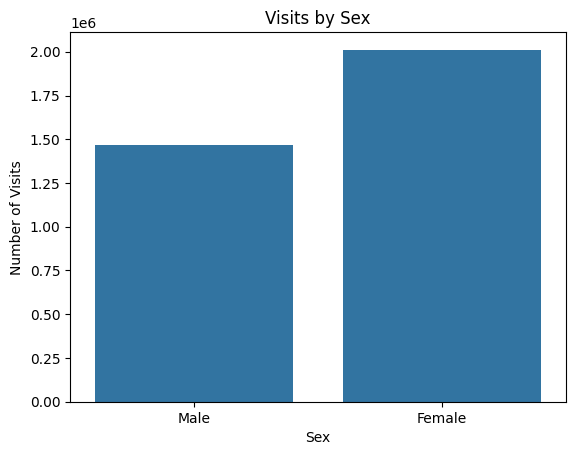

In [ ]:
sns.countplot(data=df, x='sex')
plt.title("Visits by Sex")
plt.xlabel("Sex")
plt.xticks([0, 1], ['Male', 'Female'])
plt.ylabel("Number of Visits")
plt.show()

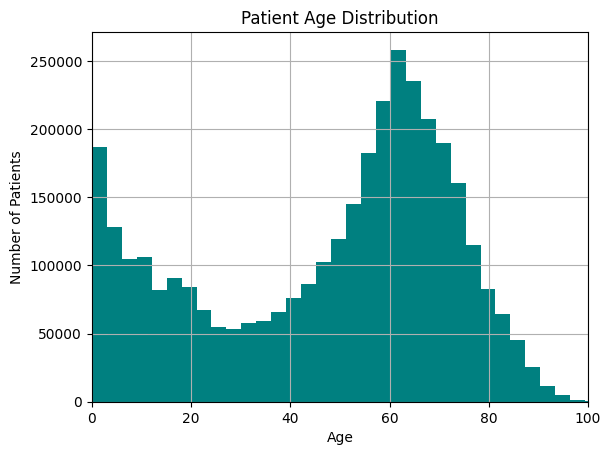

In [ ]:
df['age_year'].hist(bins=150, color='teal')
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.xlim(0, 100)
plt.ylabel("Number of Patients")
plt.show()


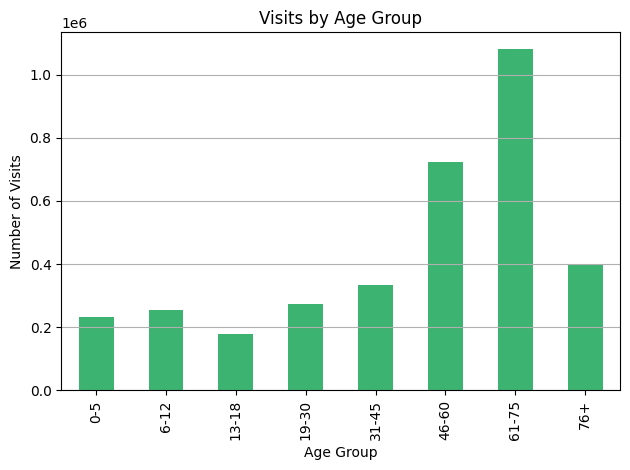

In [ ]:
# Define bins and labels
bins = [0, 5, 12, 18, 30, 45, 60, 75, 100]
labels = ['0-5', '6-12', '13-18', '19-30', '31-45', '46-60', '61-75', '76+']
df['age_group'] = pd.cut(df['age_year'], bins=bins, labels=labels, right=False)

age_group_counts = df['age_group'].value_counts().sort_index()

# Plot
age_group_counts.plot(kind='bar', color='mediumseagreen')
plt.title("Visits by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Visits")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Visit

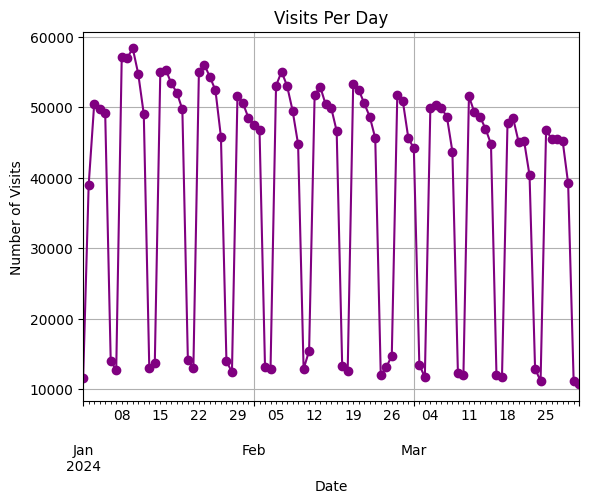

In [ ]:
df['date_serv'] = pd.to_datetime(df['date_serv'], format='%Y%m%d')

visits_per_day = df.groupby('date_serv').size()

visits_per_day.plot(marker='o', linestyle='-', color='purple')
plt.title("Visits Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Visits")
plt.grid(True)
plt.show()


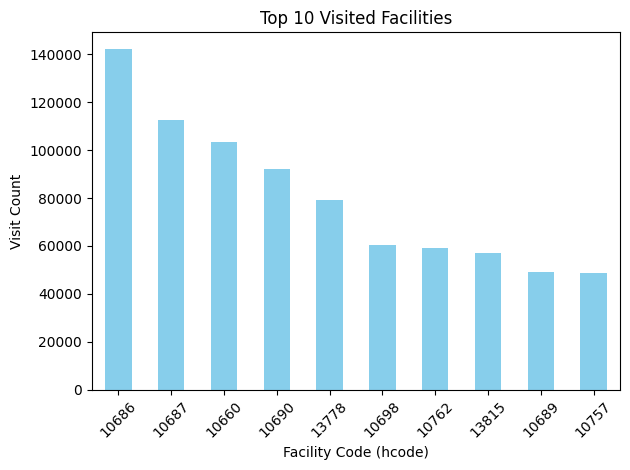

In [ ]:
top_hcodes = df['hcode'].value_counts().head(10)

top_hcodes.plot(kind='bar', color='skyblue')
plt.title("Top 10 Visited Facilities")
plt.xlabel("Facility Code (hcode)")
plt.ylabel("Visit Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Cross visits

In [ ]:
df['visit_type'] = 'in_area'
df.loc[(df['hcode'] != df['hmain']) & (df['prov1'] == df['prov2']), 'visit_type'] = 'diff_level_same_area'
# ข้ามใน pattern ไหน เช่น รพสต -> รพช ? link hosmap
df.loc[(df['hcode'] != df['hmain']) & (df['prov1'] != df['prov2']), 'visit_type'] = 'true_cross_area'

In [ ]:
total_visits = len(df)
cross_area_visits = (df['visit_type'] == 'true_cross_area').sum()
percent_cross = round(100 * cross_area_visits / total_visits, 2)

print(f"Cross-area visits: {cross_area_visits} ({percent_cross}%)")

# check data type

Cross-area visits: 3477870 (100.0%)


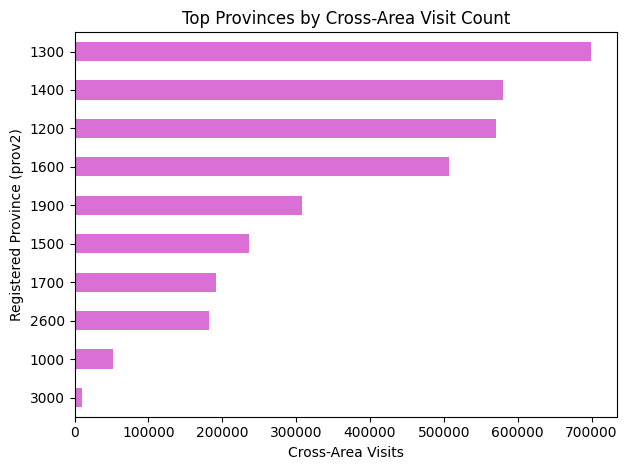

In [ ]:
cross_area_by_prov = df[df['visit_type'] == 'true_cross_area'].groupby('prov2').size().sort_values(ascending=False).head(10)

cross_area_by_prov.plot(kind='barh', color='orchid')
plt.title("Top Provinces by Cross-Area Visit Count")
plt.xlabel("Cross-Area Visits")
plt.ylabel("Registered Province (prov2)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


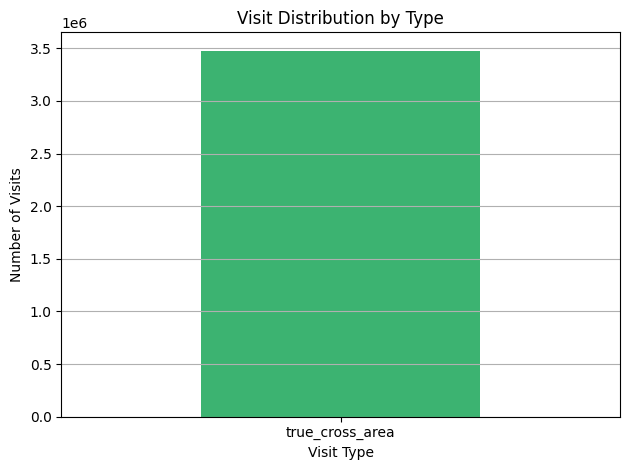

In [ ]:
visit_summary = df['visit_type'].value_counts()
visit_summary.plot(kind='bar', color=['mediumseagreen', 'skyblue', 'salmon'])
plt.title("Visit Distribution by Type")
plt.xlabel("Visit Type")
plt.ylabel("Number of Visits")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

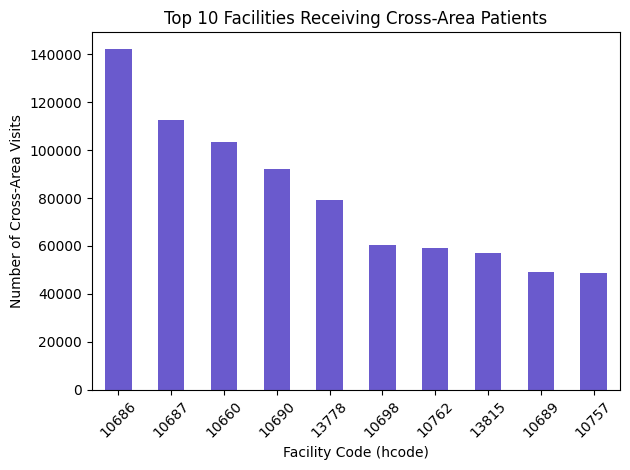

In [ ]:
top_hcode = df[df['visit_type'] == 'true_cross_area']['hcode'].value_counts().head(10)
top_hcode.plot(kind='bar', color='slateblue')
plt.title("Top 10 Facilities Receiving Cross-Area Patients")
plt.xlabel("Facility Code (hcode)")
plt.ylabel("Number of Cross-Area Visits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


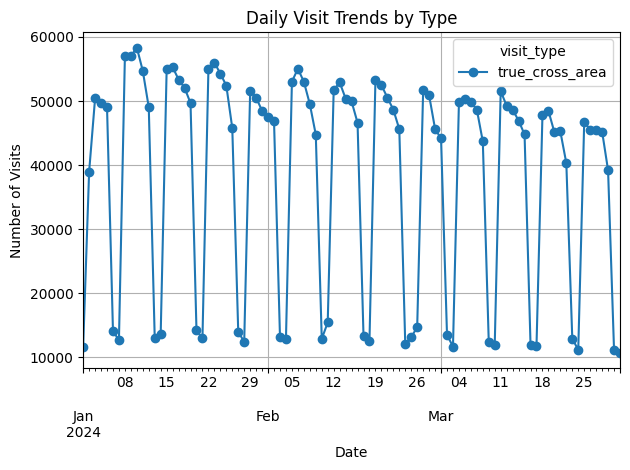

In [ ]:
daily = df.groupby(['date_serv', 'visit_type']).size().unstack().fillna(0)
daily.plot(kind='line', marker='o')
plt.title("Daily Visit Trends by Type")
plt.xlabel("Date")
plt.ylabel("Number of Visits")
plt.grid(True)
plt.tight_layout()
plt.show()


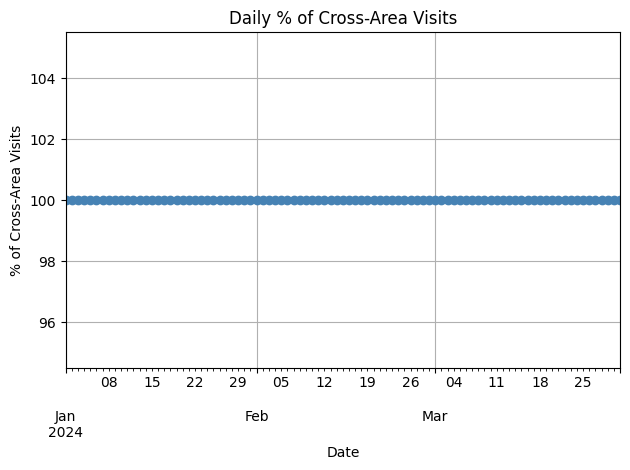

In [ ]:
# Count total visits and cross-area visits per day
daily_total = df.groupby('date_serv')['tran_id'].nunique()
# Create cross_df before using it
cross_df = df[df['visit_type'] == 'true_cross_area']
daily_cross = cross_df.groupby('date_serv')['tran_id'].nunique()

# Combine and compute %
daily_pct = (daily_cross / daily_total * 100).round(2)

# Plot
daily_pct.plot(kind='line', marker='o', color='steelblue')
plt.title("Daily % of Cross-Area Visits")
plt.xlabel("Date")
plt.ylabel("% of Cross-Area Visits")
plt.grid(True)
plt.tight_layout()
plt.show()

### Visit load

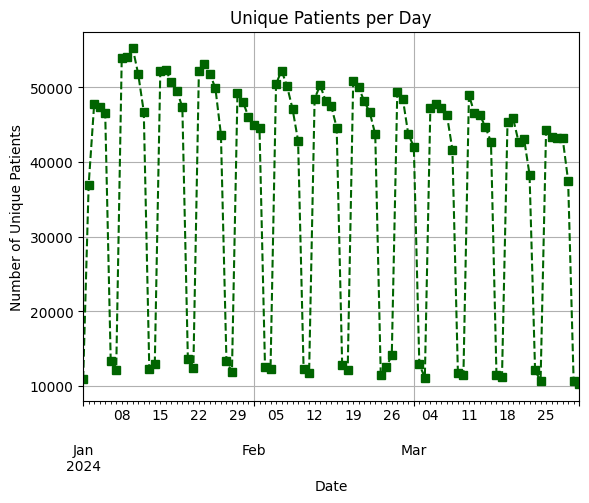

In [ ]:
unique_patients_per_day = df.groupby('date_serv')['pid'].nunique()

unique_patients_per_day.plot(marker='s', linestyle='--', color='darkgreen')
plt.title("Unique Patients per Day")
plt.xlabel("Date")
plt.ylabel("Number of Unique Patients")
plt.grid(True)
plt.show()

In [ ]:
facility_load = df.groupby(['date_serv', 'hcode']).size().reset_index(name='visits')

# Top 5 busiest facilities overall
top_facilities = df['hcode'].value_counts().head(5).index.tolist()
top_load = facility_load[facility_load['hcode'].isin(top_facilities)]

# Plot for each
plt.figure(figsize=(10, 6))
for code in top_facilities:
    data = top_load[top_load['hcode'] == code]
    plt.plot(data['date_serv'], data['visits'], label=f'Hcode {code}')

plt.title("Daily Visit Load for Top 5 Facilities")
plt.xlabel("Date")
plt.ylabel("Visit Count")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'df' is not defined

In [ ]:
repeat_visitors = df['pid'].value_counts()
repeat_visitors = repeat_visitors[repeat_visitors > 1]

print(f"🔁 Number of patients with repeat visits: {len(repeat_visitors)}")


NameError: name 'df' is not defined

In [ ]:
repeat_visitors.value_counts().sort_index().plot(kind='bar', color='tomato')
plt.title("Distribution of Repeat Visits")
plt.xlabel("Number of Visits")
plt.ylabel("Number of Patients")


# Plotting with better handling of outliers
fig, ax = plt.subplots(figsize=(12, 6))

# Limit x-axis range to improve visibility if you have extreme outliers
max_visits_to_display = 20
filtered_repeat_visits = repeat_visitors.value_counts().sort_index()
filtered_repeat_visits = filtered_repeat_visits[filtered_repeat_visits.index <= max_visits_to_display]

filtered_repeat_visits.plot(kind='bar', color='tomato', width=0.8, ax=ax)

ax.set_title("Distribution of Repeat Visits (Up to {} Visits)".format(max_visits_to_display), fontsize=16)
ax.set_xlabel("Number of Visits", fontsize=14)
ax.set_ylabel("Number of Patients", fontsize=14)

ax.tick_params(axis='x', rotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


# เส้นรพศูนย์ ชุมชน ทั่วไป
# line chart รพศูนย์ ทั่วไป สนใจ cross area เขตสุขภาพ 1-12

NameError: name 'repeat_visitors' is not defined

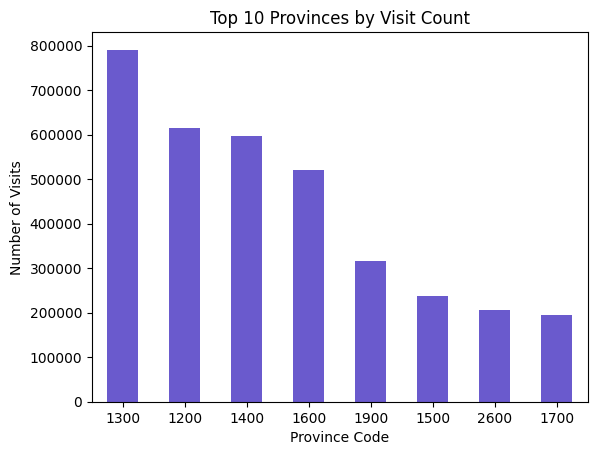

In [ ]:
# You can choose either prov1 (location of visit) or prov2 (registered province)
visits_by_province = df['prov1'].value_counts().head(10)

visits_by_province.plot(kind='bar', color='slateblue')
plt.title("Top 10 Provinces by Visit Count")
plt.xlabel("Province Code")
plt.ylabel("Number of Visits")
plt.xticks(rotation=0)
plt.show()


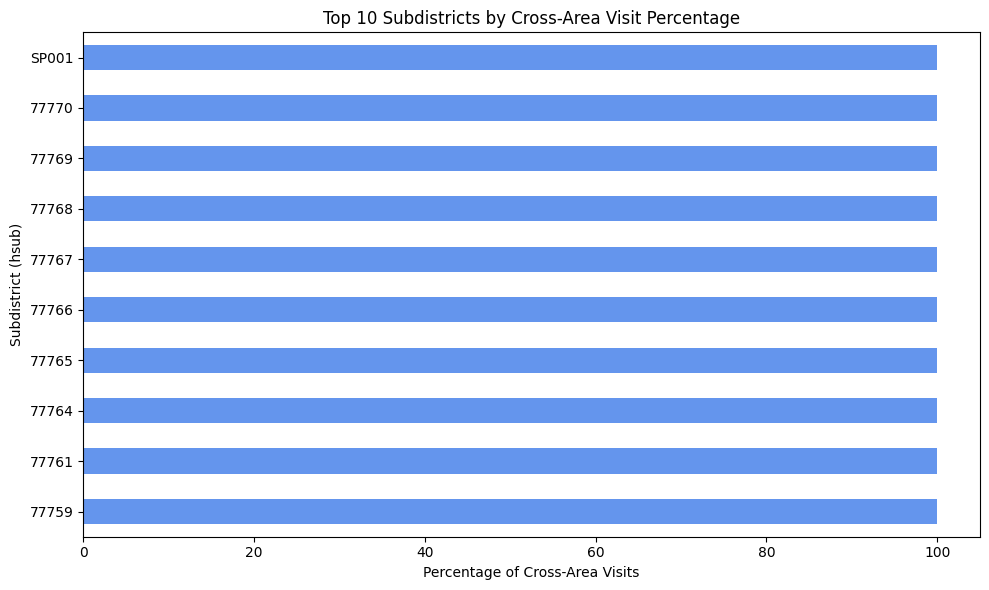

<Figure size 1000x600 with 0 Axes>

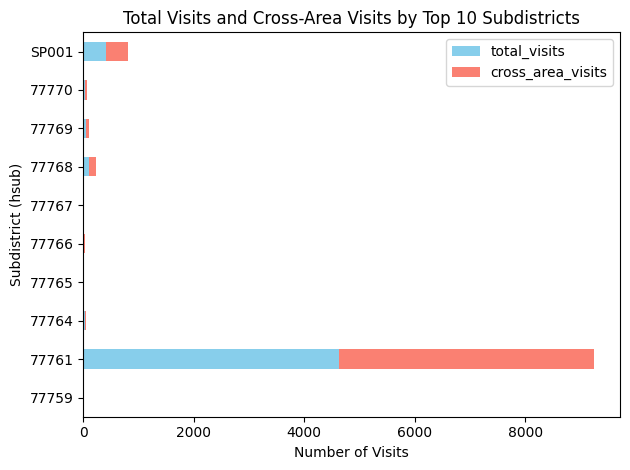

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by subdistrict (hsub) and calculate total visits and cross-area visits
subdistrict_visits = df.groupby('hsub')['tran_id'].nunique()  # Unique visits per subdistrict

# Identify cross-area visits for each subdistrict
cross_area_visits_by_hsub = df[df['visit_type'] == 'true_cross_area'].groupby('hsub')['tran_id'].nunique()

# Combine the results into one DataFrame for easier analysis
utilization_by_hsub = pd.DataFrame({
    'total_visits': subdistrict_visits,
    'cross_area_visits': cross_area_visits_by_hsub
}).fillna(0)  # Replace NaN with 0 for subdistricts with no cross-area visits

# Calculate the proportion of cross-area visits for each subdistrict
utilization_by_hsub['cross_area_percent'] = (utilization_by_hsub['cross_area_visits'] / utilization_by_hsub['total_visits']) * 100

# Sort by the cross-area visit percentage (descending)
utilization_by_hsub_sorted = utilization_by_hsub.sort_values(by='cross_area_percent', ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))

# Top 10 subdistricts by cross-area visit percentage
utilization_by_hsub_sorted.head(10)['cross_area_percent'].plot(kind='barh', color='cornflowerblue')

plt.title("Top 10 Subdistricts by Cross-Area Visit Percentage")
plt.xlabel("Percentage of Cross-Area Visits")
plt.ylabel("Subdistrict (hsub)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot total visits and cross-area visits
plt.figure(figsize=(10, 6))

# Plot visits (total and cross-area)
utilization_by_hsub_sorted.head(10)[['total_visits', 'cross_area_visits']].plot(kind='barh', stacked=True, color=['skyblue', 'salmon'])

plt.title("Total Visits and Cross-Area Visits by Top 10 Subdistricts")
plt.xlabel("Number of Visits")
plt.ylabel("Subdistrict (hsub)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# *** แต่แก้


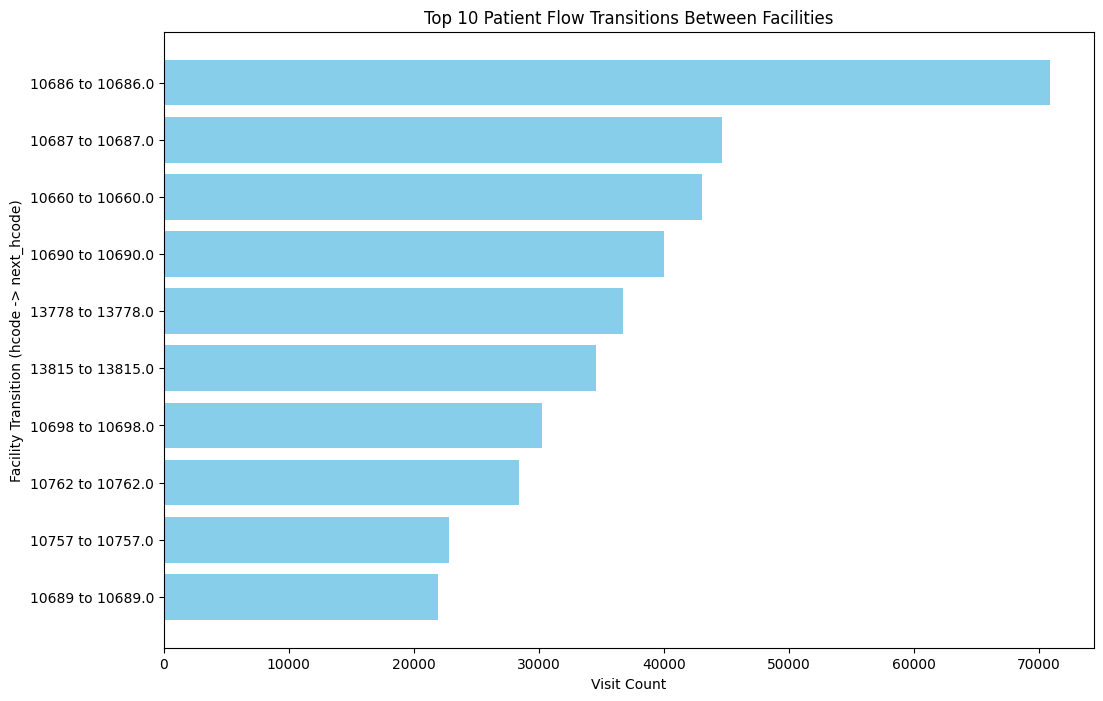

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (df) assuming you have columns like pid, date_serv, hcode (facility code)
# Replace this with your actual data if you already have it loaded
# df = pd.read_csv('your_data.csv')  # Example: Load your data

# 1. Sort the DataFrame by patient and visit date to ensure we are tracking their visits in chronological order
df_sorted = df.sort_values(by=['pid', 'date_serv'])

# 2. Create a column that tracks the next facility for the same patient
df_sorted['next_hcode'] = df_sorted.groupby('pid')['hcode'].shift(-1)

# 3. Now, we can count transitions between facilities for the same patient
# Drop rows where next_hcode is NaN (last visit), as there’s no next facility to track
flow_df = df_sorted.dropna(subset=['next_hcode'])

# 4. Create a DataFrame to count transitions (i.e., how many times patients go from one facility to another)
facility_flow = flow_df.groupby(['hcode', 'next_hcode']).size().reset_index(name='visit_count')

# 5. Sort the transitions by visit count (highest first)
facility_flow_sorted = facility_flow.sort_values(by='visit_count', ascending=False)

# 6. Plot the most common transitions (Top 10)
top_transitions = facility_flow_sorted.head(10)

import pandas as pd
import matplotlib.pyplot as plt

# ... (your previous code) ...

# 7. Plotting the bar chart
plt.figure(figsize=(12, 8))
# Convert 'hcode' and 'next_hcode' to strings before concatenation
plt.barh(top_transitions['hcode'].astype(str) + ' to ' + top_transitions['next_hcode'].astype(str),
        top_transitions['visit_count'], color='skyblue')
plt.xlabel('Visit Count')
plt.ylabel('Facility Transition (hcode -> next_hcode)')
plt.title('Top 10 Patient Flow Transitions Between Facilities')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest counts at the top
plt.show()

# ***


In [ ]:
import plotly.graph_objects as go

# 1. Sort the DataFrame by patient and visit date to ensure we are tracking their visits in chronological order
df_sorted = df.sort_values(by=['pid', 'date_serv'])

# 2. Create a column that tracks the next facility for the same patient
df_sorted['next_hcode'] = df_sorted.groupby('pid')['hcode'].shift(-1)

# 3. Filter transitions to only include those between different facilities
flow_df = df_sorted[df_sorted['hcode'] != df_sorted['next_hcode']].dropna(subset=['next_hcode'])

# 4. Create a DataFrame to count transitions (i.e., how many times patients go from one facility to another)
facility_flow = flow_df.groupby(['hcode', 'next_hcode']).size().reset_index(name='visit_count')

# 5. Sort the transitions by visit count (highest first)
facility_flow_sorted = facility_flow.sort_values(by='visit_count', ascending=False)

# 6. Select the top 10 transitions
top_transitions = facility_flow_sorted.head(20)

# 7. Create a list of unique facility codes
facilities = list(set(top_transitions['hcode'].unique()).union(set(top_transitions['next_hcode'].unique())))

# 8. Create a source-target-value list for the Sankey diagram
source = [facilities.index(hcode) for hcode in top_transitions['hcode']]
target = [facilities.index(next_hcode) for next_hcode in top_transitions['next_hcode']]
value = top_transitions['visit_count'].tolist()


fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=facilities,
        color="blue"
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])


fig.update_layout(
    title_text="Top 10 Patient Flow Transitions Between Different Facilities",
    font_size=10
)

fig.show()


# hmain -> hmain (expected ตามสิทธิ) , hmain to hcode ดูโรค รพชุมชนดูแลได้? ดู pdx , ดู pattern level รพช -> รพสต


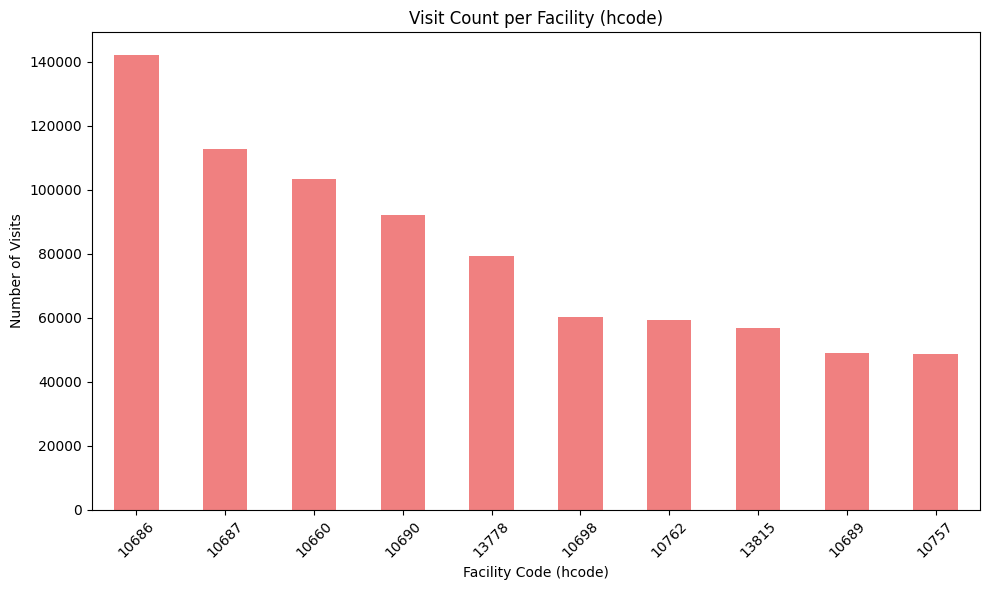

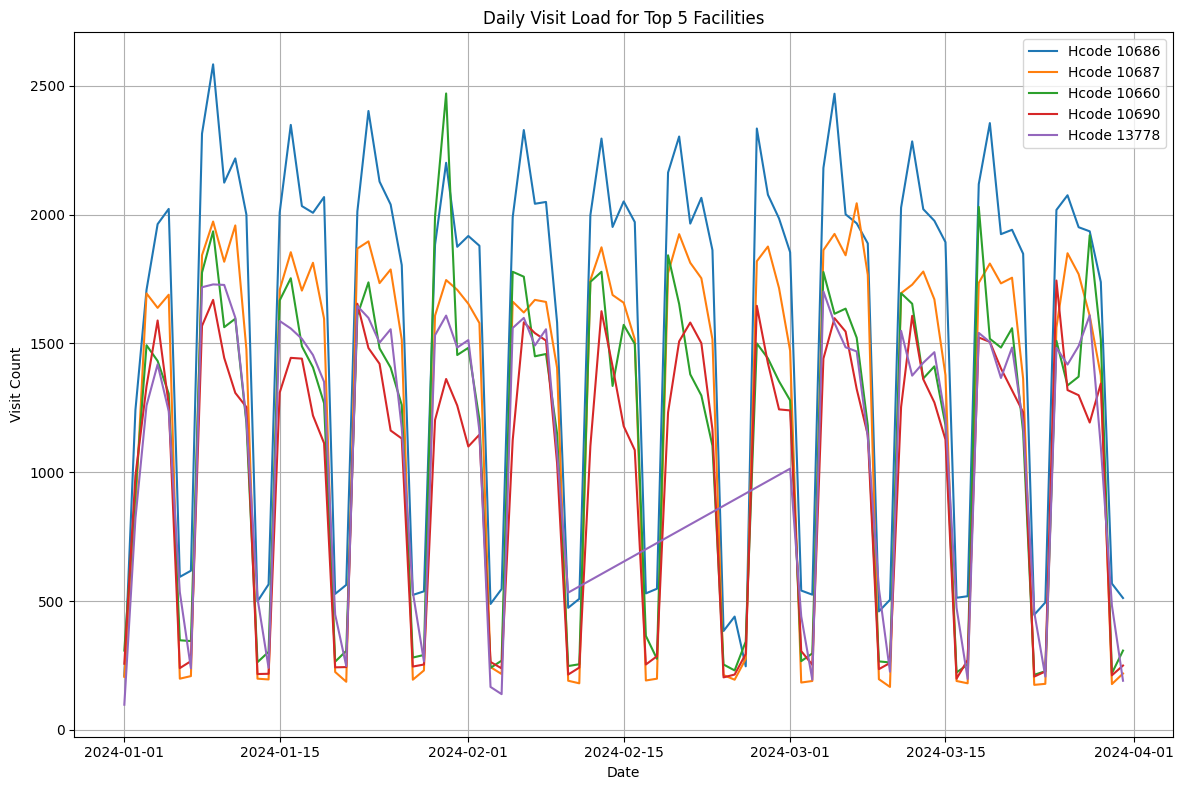

In [ ]:
# Count the number of visits per facility
visits_per_facility = df['hcode'].value_counts().head(10)

# Plot the distribution of visits across facilities
plt.figure(figsize=(10, 6))
visits_per_facility.plot(kind='bar', color='lightcoral')
plt.title("Visit Count per Facility (hcode)")
plt.xlabel("Facility Code (hcode)")
plt.ylabel("Number of Visits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# If you want to see the peak demand periods (e.g., by day):
facility_load = df.groupby(['date_serv', 'hcode']).size().reset_index(name='visit_count')

# Plot the top 5 busiest facilities over time
top_facilities = visits_per_facility.head(5).index.tolist()
top_load = facility_load[facility_load['hcode'].isin(top_facilities)]

plt.figure(figsize=(12, 8))
for code in top_facilities:
    data = top_load[top_load['hcode'] == code]
    plt.plot(data['date_serv'], data['visit_count'], label=f'Hcode {code}')

plt.title("Daily Visit Load for Top 5 Facilities")
plt.xlabel("Date")
plt.ylabel("Visit Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# แก้เปนเทียบ level รพช รพสต, เทียบ ก่อนหลัง นโยบาย, ัyear on year



In [ ]:
# 1. Top Diagnoses for Cross-Area Visits:
top_diag_cross = df[df['visit_type'] == 'true_cross_area']['pdx'].value_counts().head(10)
print("Top 10 Diagnoses for Cross-Area Visits:")
print(top_diag_cross)


# 2. Diagnoses and Age Group:
# Group by age group and get the top 10 diagnoses for each group
top_diag_by_age = df.groupby('age_group')['pdx'].apply(lambda x: x.value_counts().head(10))
print("Top 10 Diagnoses by Age Group:")
print(top_diag_by_age)

# ***

Top 10 Diagnoses for Cross-Area Visits:
pdx
I10     265269
Z480    255419
E119    159979
J00     119542
Z000     79580
Z123     75474
Z012     74431
Z017     61806
Z133     60762
Z001     44350
Name: count, dtype: int64


<ipython-input-77-87822b4b5263>:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Top 10 Diagnoses by Age Group:
age_group      
0-5        J00     31781
           Z001    24578
           Z012    12480
           Z271    12369
           Z241     7691
                   ...  
76+        Z718     8399
           Z133     7563
           R42      5852
           Z012     5153
           J00      4138
Name: pdx, Length: 80, dtype: int64


# E-claim

In [ ]:
file_path = "/content/drive/MyDrive/OneID/v_t_f_eclaim_indiv_flat_202504271202.csv"

with open(file_path, 'r') as f:
    row_count = sum(1 for line in f)

print(f"Total data rows: {row_count}")

Total data rows: 14595353


In [ ]:
chunksize = 100000
filtered_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    # Convert date_serv to string to filter by date prefix
    chunk['dateadm'] = chunk['dateadm'].astype(str)

    # Filter for first week of Jan 2023 (20230101 to 20230107)
    period = chunk[chunk['dateadm'].between("20240101", "20240331")]

    filtered_chunks.append(period)

# Combine all filtered chunks into a single DataFrame
eclaim_df = pd.concat(filtered_chunks, ignore_index=True)


del filtered_chunks
del chunk
del period
gc.collect()

# Show sample
print(eclaim_df.head())
print(f"Total rows loaded: {len(eclaim_df)}")


    dateadm  dateadm_str    month  \
0  20240314     20240314  2024-03   
1  20240109     20240109  2024-01   
2  20240330     20240330  2024-03   
3  20240315     20240315  2024-03   
4  20240328     20240328  2024-03   

                                             tran_id  \
0  aec359568bc104f5335c83900b52f1b8c6946c9d5ff6eb...   
1  0e40f6fbb6ba718541d7c00953752f63f45bda8cefdd4a...   
2  0f296c48ec691b31eece31f72eae1ca3b9451f1b929271...   
3  b785c80075becd89a4a1673c379e804f2f64c2c3ff4f20...   
4  ac1222f7018b6c2f05d5a9495b902f7fecc02dc21a632f...   

                                                 pid  sex  age_year  hcode  \
0  a9f8cdeef8ec2324b5992d595bd6c6f6ab3d46448fade5...  2.0      40.0  10761   
1  fbf3a7e3b55c7804a157ffa150e8ee309556b4b3e57918...  1.0      42.0  10760   
2  45e4f863a51daf11853a3fbeaa0919b0932b768b5855b9...  1.0       1.0  10810   
3  2578cc52db688c2a2592eacad41bb7860deb6ba3246032...  2.0      64.0  10807   
4  eb1ec9ecc1c7769ca5f693a436d56e702d394f7d46b3e1.

In [ ]:
eclaim_df

# link oppp ผ่าน pid, date, hcode

,dateadm,dateadm_str,month,tran_id,pid,sex,age_year,hcode,hmain2,prov1,prov2,maininscl_af,totl_amt,act_amt,pdx
0,20240314,20240314,2024-03,aec359568bc104f5335c83900b52f1b8c6946c9d5ff6eb...,a9f8cdeef8ec2324b5992d595bd6c6f6ab3d46448fade5...,2.0,40.0,10761,10761,1300,1300,WEL,NaN,NaN,G439
1,20240109,20240109,2024-01,0e40f6fbb6ba718541d7c00953752f63f45bda8cefdd4a...,fbf3a7e3b55c7804a157ffa150e8ee309556b4b3e57918...,1.0,42.0,10760,11049,1200,3800,UCS,330.00,429.0,Z242
2,20240330,20240330,2024-03,0f296c48ec691b31eece31f72eae1ca3b9451f1b929271...,45e4f863a51daf11853a3fbeaa0919b0932b768b5855b9...,1.0,1.0,10810,10810,1900,1900,WEL,NaN,NaN,Z242
3,20240315,20240315,2024-03,b785c80075becd89a4a1673c379e804f2f64c2c3ff4f20...,2578cc52db688c2a2592eacad41bb7860deb6ba3246032...,2.0,64.0,10807,10807,1900,1900,WEL,NaN,NaN,K081
4,20240328,20240328,2024-03,ac1222f7018b6c2f05d5a9495b902f7fecc02dc21a632f...,eb1ec9ecc1c7769ca5f693a436d56e702d394f7d46b3e1...,2.0,68.0,10661,10782,1900,1500,WEL,NaN,NaN,Z016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807111,20240127,20240127,2024-01,9d7aae101d58824edec00fab93d3e2b6a076db72701987...,40bcf37e2e560efa8d25797431ec0002bcff4566821d09...,1.0,19.0,14928,11482,1600,1000,WEL,1020.00,1020.0,J029
807112,20240201,20240201,2024-02,ccb80489ef978a9f0b0ea1d2d29e22e843577803aa451c...,26d9fcf0542644578f201337625b0cee4a0942ee498df1...,2.0,20.0,41332,10713,1300,5000,UCS,0.00,80.0,Z138
807113,20240213,20240213,2024-02,a30b7f5a30864dfe7e51682c2eaf24c0478f4b75c553c5...,1bdca2ee119050abed3db676b3d6b3face2af338088f30...,2.0,21.0,10809,10764,1900,1300,UCS,183.25,147.0,J00
807114,20240313,20240313,2024-03,ffb296f89ecdbdad394e81216c5a743cb1cc9f08d40886...,87b76e56c694066966d77dd7592f0c4ff6742f32d0b329...,2.0,55.0,10757,10686,1200,1200,UCS,NaN,NaN,E785


# Subfund

In [ ]:
file_path = "/content/drive/MyDrive/OneID/v_t_m_sum_subfund_202504271227.csv"

with open(file_path, 'r') as f:
    row_count = sum(1 for line in f)

print(f"Total data rows: {row_count}")

Total data rows: 14610002


In [ ]:
chunksize = 100000
filtered_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    filtered_chunk = chunk[chunk['tran_id'].isin(set(eclaim_df['tran_id']))]
    filtered_chunks.append(filtered_chunk)

# Combine all filtered chunks into a single DataFrame
subfund_df = pd.concat(filtered_chunks, ignore_index=True)


del filtered_chunks
del filtered_chunk
del chunk

gc.collect()

# Show sample
print(subfund_df.head())
print(f"Total rows loaded: {len(subfund_df)}")

                                             tran_id  hcode   sub_fund  \
0  46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...  10689  OPAE-DRUG   
1  46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...  10689       OPAE   
2  46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...  10689       OPAE   
3  46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...  10689       OPAE   
4  46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...  10689  OPAE-DRUG   

   totl_amt  act_amt  item_code    item_source  
0     30.00    30.00  1002985+1         M_DRUG  
1    300.00     0.00   35109+12  M_SPECIALDIAG  
2    300.00     0.00   52410+17  M_SPECIALDIAG  
3     50.00     0.00   55020+19  M_SPECIALDIAG  
4      8.25     7.25  1002987+2         M_DRUG  
Total rows loaded: 494337


In [ ]:
subfund_df

# link ผ่าน tranid กับ eclaim ค่อย oppp
# eclaim = subset of oppp
# มี tran id ซ้ำ เพราะ visit เดียวกัน เบิกคนละแบบ -> group tranid รวมกัน
# item code source ไม่ต้อง

,tran_id,hcode,sub_fund,totl_amt,act_amt,item_code,item_source
0,46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...,10689,OPAE-DRUG,30.00,30.00,1002985+1,M_DRUG
1,46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...,10689,OPAE,300.00,0.00,35109+12,M_SPECIALDIAG
2,46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...,10689,OPAE,300.00,0.00,52410+17,M_SPECIALDIAG
3,46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...,10689,OPAE,50.00,0.00,55020+19,M_SPECIALDIAG
4,46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...,10689,OPAE-DRUG,8.25,7.25,1002987+2,M_DRUG
...,...,...,...,...,...,...,...
494332,e7f861c66ef81bbb5296735c3b17292209e51be7f2d8e4...,10816,EXCEPT,NaN,NaN,UUC2,NaN
494333,ab02e3c61a31473ff5567f380a4137202add529b49e65a...,10816,EXCEPT,NaN,NaN,UUC2,NaN
494334,241a7b97fea18862beff364119ecf436c9045e8de2b538...,10816,EXCEPT,NaN,NaN,UUC2,NaN
494335,e4c250f7bde6fb37ca3c103fdcea525b8a8e4cb69b3177...,10816,EXCEPT,NaN,NaN,UUC2,NaN


# Data linking

In [ ]:
filtered_eclaim_df = eclaim_df[
    (eclaim_df['pid'].isin(df['pid'].tolist())) &
    (eclaim_df['act_amt'] > 0)
]
filtered_eclaim_df

,dateadm,dateadm_str,month,tran_id,pid,sex,age_year,hcode,hmain2,prov1,prov2,maininscl_af,totl_amt,act_amt,pdx
1,20240109,20240109,2024-01,0e40f6fbb6ba718541d7c00953752f63f45bda8cefdd4a...,fbf3a7e3b55c7804a157ffa150e8ee309556b4b3e57918...,1.0,42.0,10760,11049,1200,3800,UCS,330.00,429.00,Z242
5,20240301,20240301,2024-03,4cc93416ff63314e8e24238577b4740160e32ec5c105e2...,839fcef4b01b770caf1fb99a0a537ae17300899e26a328...,2.0,24.0,10798,10798,1700,1700,UCS,0.00,80.00,Z130
6,20240104,20240104,2024-01,a3deba39461f70c5a4a0e35cd4eb167d7db44654b83908...,e897e3d709ece7fa0e31b1a64a305171ca3806c3ffa8e0...,2.0,59.0,10772,13670,1400,1000,UCS,209.00,259.00,L020
7,20240228,20240228,2024-02,8634327893f82e4baa694d59229a1b6f39700fc22dd4bf...,5c1c3e5a00aa0b29181c4dbef1d5dc822284fe30344e75...,1.0,53.0,13815,10787,1200,1500,WEL,90.00,90.00,I251
9,20240323,20240323,2024-03,c2c4e37828522fada540e33065a3cdc28df55d2993a898...,a221cb03f6efb474604dd2af26621fc2cf5c7becbaf2e4...,1.0,15.0,31161,31161,1300,1300,WEL,0.00,100.00,Z000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807107,20240222,20240222,2024-02,950a6e51129c7538fdea188e3ce3b17984508d88c7bc3d...,fc2752cd96fb57685b697018c9d67f7b3b8acad2418fd7...,2.0,66.0,10689,10785,1500,1500,WEL,100.00,100.00,H201
807108,20240224,20240224,2024-02,e37a9fc64ffc7f745d37e7d3f1029c6fb6dfb09450d093...,9684181de48262a6fb6de4bc08f399c5691d5a8a719280...,2.0,54.0,44851,10794,1600,1600,WEL,530.52,530.52,U5732
807110,20240129,20240129,2024-01,f53c3d095bf9748a79304fa0595ab262a86d7bcc4105ae...,1d27543c5aff050aa5e1327c3636f7e6acc877e7dbdd3d...,2.0,62.0,10661,10815,1900,1900,WEL,2540.00,3180.00,C73
807112,20240201,20240201,2024-02,ccb80489ef978a9f0b0ea1d2d29e22e843577803aa451c...,26d9fcf0542644578f201337625b0cee4a0942ee498df1...,2.0,20.0,41332,10713,1300,5000,UCS,0.00,80.00,Z138


In [ ]:
filtered_subfund_df = subfund_df[
    (subfund_df['tran_id'].isin(filtered_eclaim_df['tran_id'].tolist())) &
    (subfund_df['act_amt'] > 0)
]
filtered_subfund_df

,tran_id,hcode,sub_fund,totl_amt,act_amt,item_code,item_source
0,46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...,10689,OPAE-DRUG,30.00,30.00,1002985+1,M_DRUG
4,46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...,10689,OPAE-DRUG,8.25,7.25,1002987+2,M_DRUG
5,46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...,10689,OPAE-DRUG,22.00,35.00,1001516+3,M_DRUG
6,46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...,10689,OPAE-DRUG,0.00,157.50,1001566+4,M_DRUG
7,46f30b4043c0894487464e8dec6adc9ba11644e70f8c65...,10689,OPAE-DRUG,30.00,30.00,1002579+5,M_DRUG
...,...,...,...,...,...,...,...
494301,fcfa455e47007cc341db57ccb0ef93876f47cac627d4de...,10661,OPINST,2520.00,2016.00,5703A+1,M_INSTRUMENT
494302,fcfa455e47007cc341db57ccb0ef93876f47cac627d4de...,10661,CANCER,50.00,80.00,55020+1,M_SPECIALDIAG
494304,54e82f9eee58fcb1c610143ee8a7e831cc03e5f292ab16...,10661,OPINST,2100.00,1680.00,5703A+1,M_INSTRUMENT
494305,54e82f9eee58fcb1c610143ee8a7e831cc03e5f292ab16...,10661,CANCER,50.00,80.00,55020+1,M_SPECIALDIAG


In [ ]:
# ลอง link ดีๆ

In [ ]:
print("Average เบิก (totl_amt):", filtered_eclaim_df['totl_amt'].mean())
print("Average จ่ายจริง (act_amt):", filtered_eclaim_df['act_amt'].mean())


Average เบิก (totl_amt): 553.9090610894219
Average จ่ายจริง (act_amt): 571.176511743199


     hcode      totl_amt       act_amt
875  24681  13500.000000  13500.000000
820  11835  13500.000000  13500.000000
830  14187  10000.000000  10000.000000
831  14199   2917.964732   2786.908876
827  13778   2884.250672   2599.158380
843  14923   2454.560538   2441.916978
817  11789   2245.000000    885.250000
841  14904   1995.925335   1893.102569
825  12261   1768.333333   1695.000000
108   1112   1661.818182   1121.136364


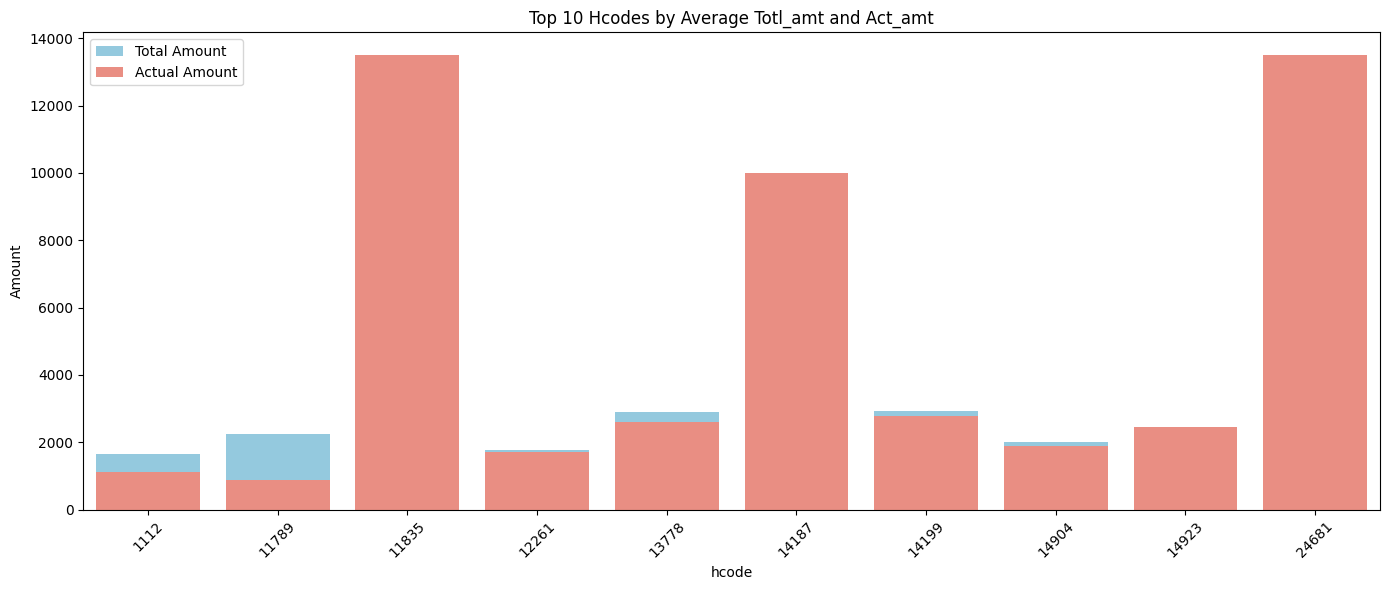

In [ ]:
hcode_summary = filtered_eclaim_df.groupby('hcode')[['totl_amt', 'act_amt']].mean().reset_index()

print(hcode_summary.sort_values('totl_amt', ascending=False).head(10))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
top_hcodes = hcode_summary.sort_values('totl_amt', ascending=False).head(10)

sns.barplot(data=top_hcodes, x='hcode', y='totl_amt', color='skyblue', label='Total Amount')
sns.barplot(data=top_hcodes, x='hcode', y='act_amt', color='salmon', label='Actual Amount')

plt.title('Top 10 Hcodes by Average Totl_amt and Act_amt')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ***

   prov1    totl_amt     act_amt
1   1300  734.236994  703.030038
4   1600  685.816873  703.447523
7   2600  647.227418  784.452102
6   1900  517.175226  485.320477
3   1500  472.479877  527.549235
0   1200  432.640036  468.820760
2   1400  389.637441  413.354374
5   1700  380.105261  441.116338


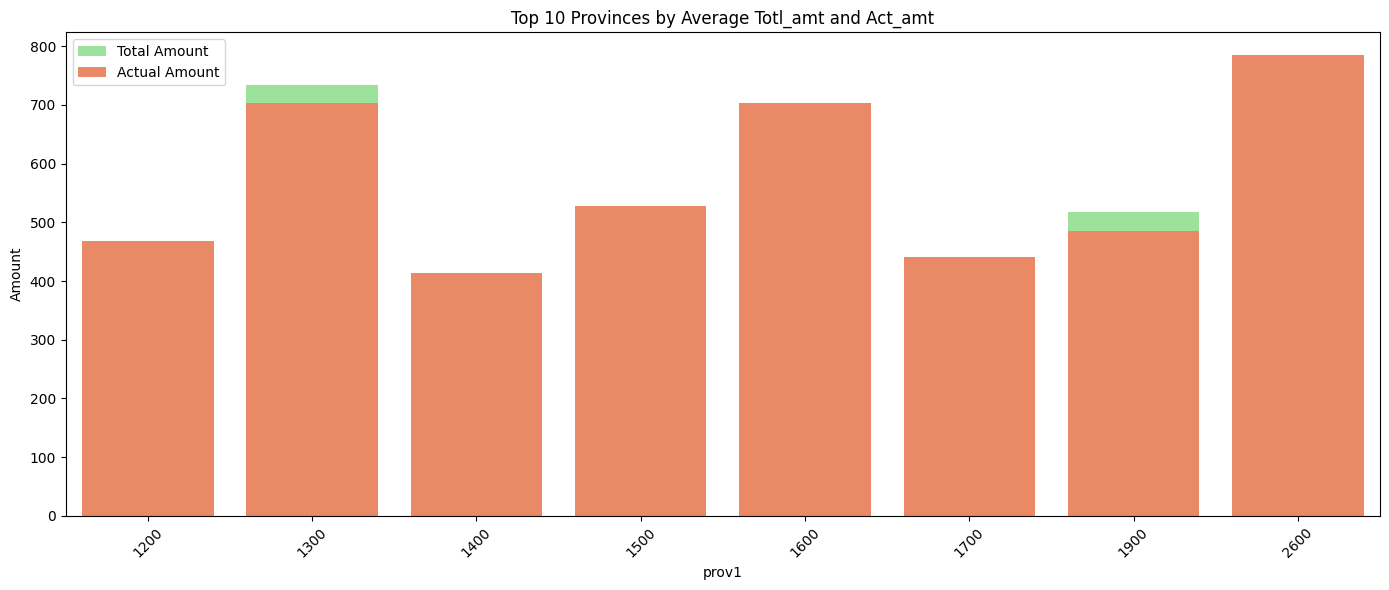

In [ ]:
prov_summary = filtered_eclaim_df.groupby('prov1')[['totl_amt', 'act_amt']].mean().reset_index()

print(prov_summary.sort_values('totl_amt', ascending=False).head(10))

plt.figure(figsize=(14, 6))
top_provs = prov_summary.sort_values('totl_amt', ascending=False).head(10)

sns.barplot(data=top_provs, x='prov1', y='totl_amt', color='lightgreen', label='Total Amount')
sns.barplot(data=top_provs, x='prov1', y='act_amt', color='coral', label='Actual Amount')

plt.title('Top 10 Provinces by Average Totl_amt and Act_amt')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ***

        pdx      totl_amt       act_amt
569    C929  62634.222222   1601.666667
4600  S7281  52749.750000  23131.250000
746     D67  50048.000000     60.000000
499    C762  36610.000000    117.500000
575    C951  34642.642857   1282.250000
4243   S069  21759.000000  21969.500000
745     D66  21471.383333    453.966667
495    C751  18866.500000   4941.583333
3883   Q244  18757.500000  16381.000000
5328   Z458  18280.000000  14980.000000


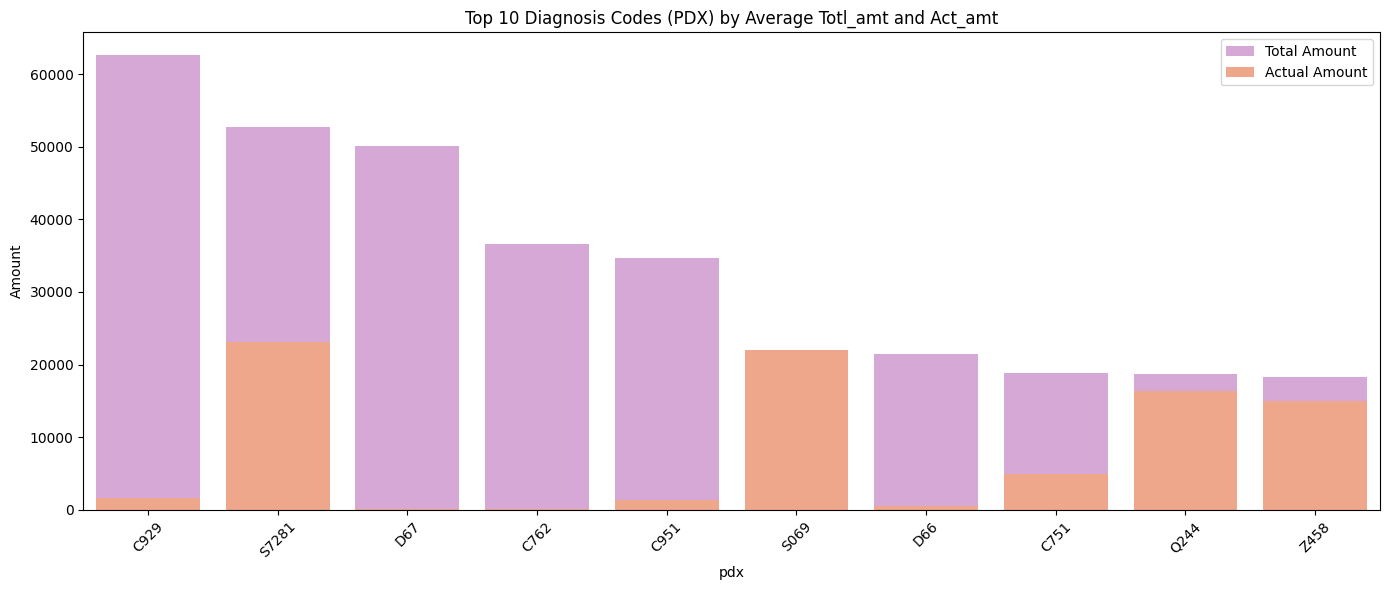

In [ ]:
pdx_summary = filtered_eclaim_df.groupby('pdx')[['totl_amt', 'act_amt']].mean().reset_index()

print(pdx_summary.sort_values('totl_amt', ascending=False).head(10))

plt.figure(figsize=(14, 6))
top_pdx = pdx_summary.sort_values('totl_amt', ascending=False).head(10)

sns.barplot(data=top_pdx, x='pdx', y='totl_amt', color='plum', label='Total Amount')
sns.barplot(data=top_pdx, x='pdx', y='act_amt', color='lightsalmon', label='Actual Amount')

plt.title('Top 10 Diagnosis Codes (PDX) by Average Totl_amt and Act_amt')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# เอาแค่ act amt ****


In [ ]:
# Create ratio column
filtered_eclaim_df['ratio'] = filtered_eclaim_df['act_amt'] / filtered_eclaim_df['totl_amt']

# By hospital
hcode_ratio = filtered_eclaim_df.groupby('hcode')['ratio'].mean().reset_index()

# By province
prov_ratio = filtered_eclaim_df.groupby('prov1')['ratio'].mean().reset_index()

# By disease
pdx_ratio = filtered_eclaim_df.groupby('pdx')['ratio'].mean().reset_index()

# Show samples
print(hcode_ratio.sort_values('ratio').head(10))
print(prov_ratio.sort_values('ratio').head(10))
print(pdx_ratio.sort_values('ratio').head(10))


<ipython-input-72-c82f61122fa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_eclaim_df['ratio'] = filtered_eclaim_df['act_amt'] / filtered_eclaim_df['totl_amt']


     hcode     ratio
683   1803  0.259259
586   1694  0.302253
582   1688  0.349596
817  11789  0.394321
3     1000  0.417372
847  15244  0.483224
578   1684  0.488352
311   1328  0.513408
66    1070  0.514089
24    1025  0.528954
   prov1  ratio
0   1200    inf
1   1300    inf
2   1400    inf
3   1500    inf
4   1600    inf
5   1700    inf
6   1900    inf
7   2600    inf
         pdx     ratio
4527   S6241  0.013109
908     E831  0.014903
168     B201  0.026316
4593  S72309  0.033704
3813    O750  0.035071
69      A409  0.045933
172     B205  0.055422
2152     K02  0.109382
3506    M993  0.115000
60      A259  0.117096


In [ ]:
# Create difference column
filtered_eclaim_df['diff_amt'] = filtered_eclaim_df['totl_amt'] - filtered_eclaim_df['act_amt']

# Sort by biggest difference
outliers = filtered_eclaim_df.sort_values('diff_amt', ascending=False)

# Show top 10 worst cases
print(outliers[['hcode', 'prov1', 'pdx', 'totl_amt', 'act_amt', 'diff_amt']].head(10))


<ipython-input-73-343b647c5417>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_eclaim_df['diff_amt'] = filtered_eclaim_df['totl_amt'] - filtered_eclaim_df['act_amt']


        hcode  prov1   pdx  totl_amt  act_amt   diff_amt
116339  10687   1300  C921  316585.0  4775.00  311810.00
674049  10687   1300  C921  312285.0   525.00  311760.00
271740  10687   1300  C921  280268.0   498.00  279770.00
269842  10687   1300  C929  280865.0  1305.00  279560.00
189364  10687   1300  C951  234201.0   464.25  233736.75
660363  10687   1300  C929  234375.0   690.00  233685.00
84652   10687   1300  C921  209935.0    95.00  209840.00
663207  10687   1300  C921  214525.0  4780.00  209745.00
757     10687   1300  C921  158220.0   220.00  158000.00
714207  10661   1900   D66  131320.0    70.00  131250.00


In [ ]:
pdx_diff = filtered_eclaim_df.groupby('pdx').agg({
    'totl_amt':'sum',
    'act_amt':'sum'
}).reset_index()

pdx_diff['ratio'] = pdx_diff['act_amt'] / pdx_diff['totl_amt']
pdx_diff_sorted = pdx_diff.sort_values('ratio')

# See worst paid disease codes
print(pdx_diff_sorted.head(10))


         pdx   totl_amt   act_amt     ratio
746      D67  150144.00    180.00  0.001199
499     C762   73220.00    235.00  0.003210
4527   S6241    4481.50     58.75  0.013109
908     E831    6710.00    100.00  0.014903
745      D66  322070.75   6809.50  0.021143
569     C929  563708.00  14415.00  0.025572
168     B201    1900.00     50.00  0.026316
4593  S72309   14835.00    500.00  0.033704
3813    O750    1026.50     36.00  0.035071
575     C951  242498.50   8975.75  0.037014


In [ ]:
# Filter for subfunds starting with "WALKIN_"
filtered_subfund = filtered_subfund_df[filtered_subfund_df['sub_fund'].str.startswith('WALKIN_')]

subfund_analysis = filtered_subfund.groupby(['sub_fund', 'hcode', 'item_code'])[['totl_amt', 'act_amt']].sum().reset_index()

subfund_analysis['ratio'] = subfund_analysis['act_amt'] / subfund_analysis['totl_amt']

subfund_analysis['amt_diff'] = subfund_analysis['totl_amt'] - subfund_analysis['act_amt']


<ipython-input-95-d9943b79eb82>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subfund_analysis, x='sub_fund', y='amt_diff', palette='Set2')


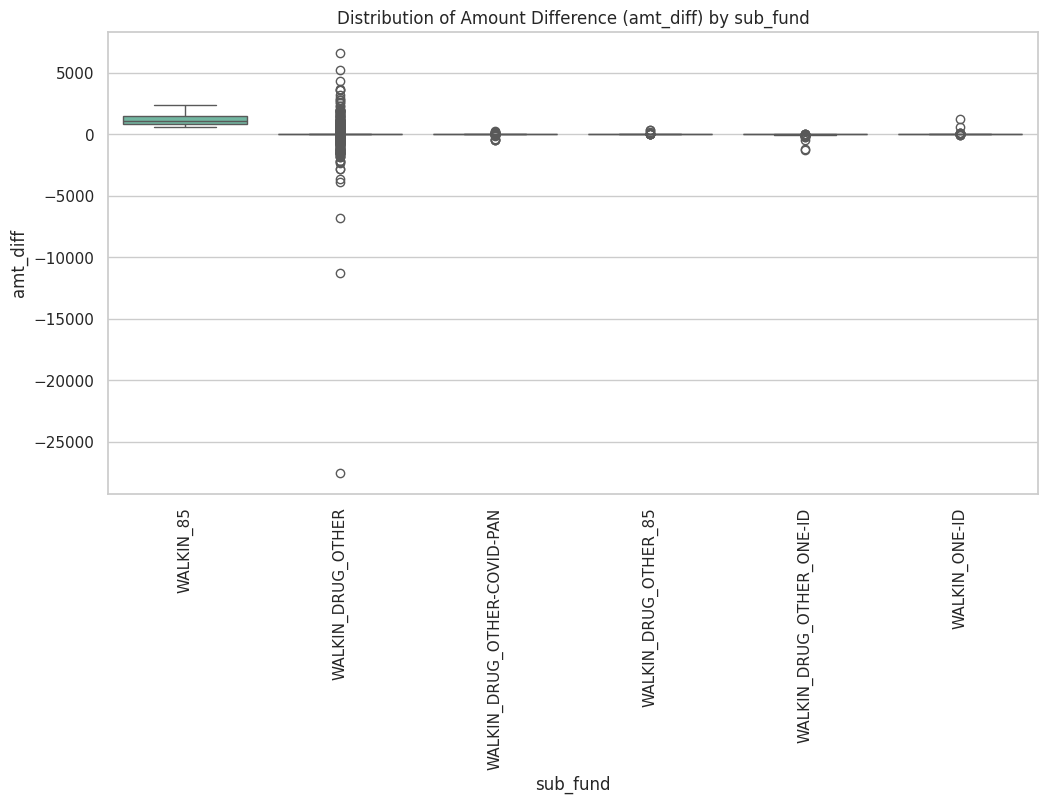

<ipython-input-95-d9943b79eb82>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subfund_analysis, x='sub_fund', y='ratio', palette='Set2')


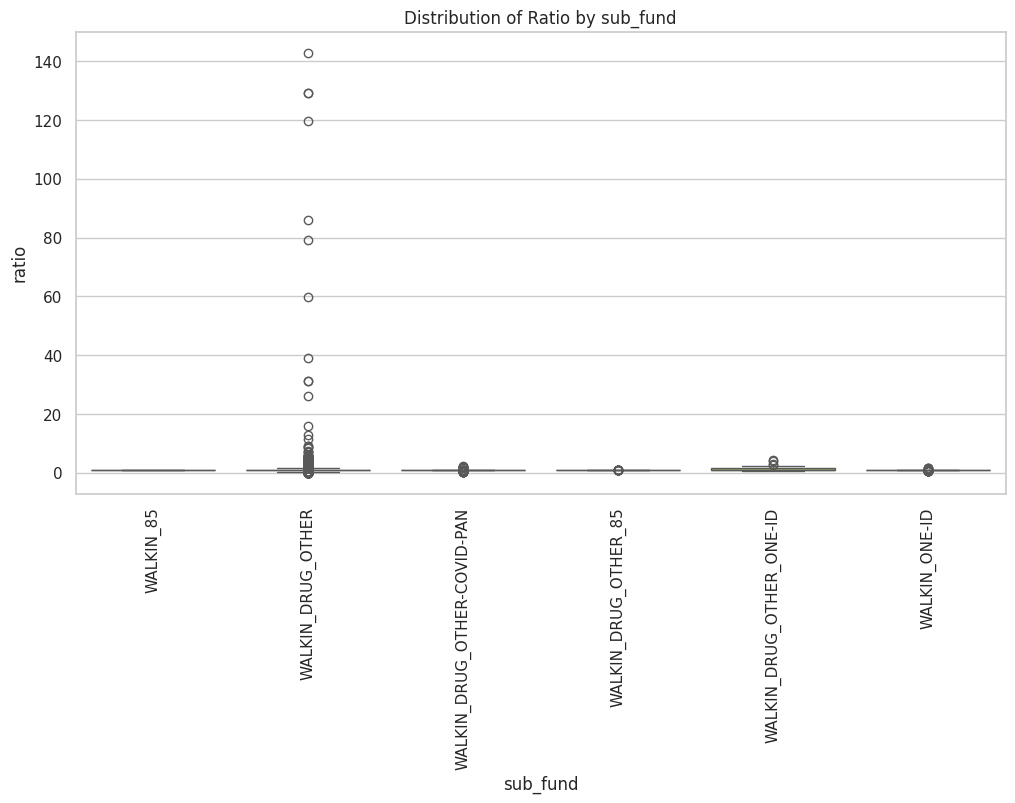

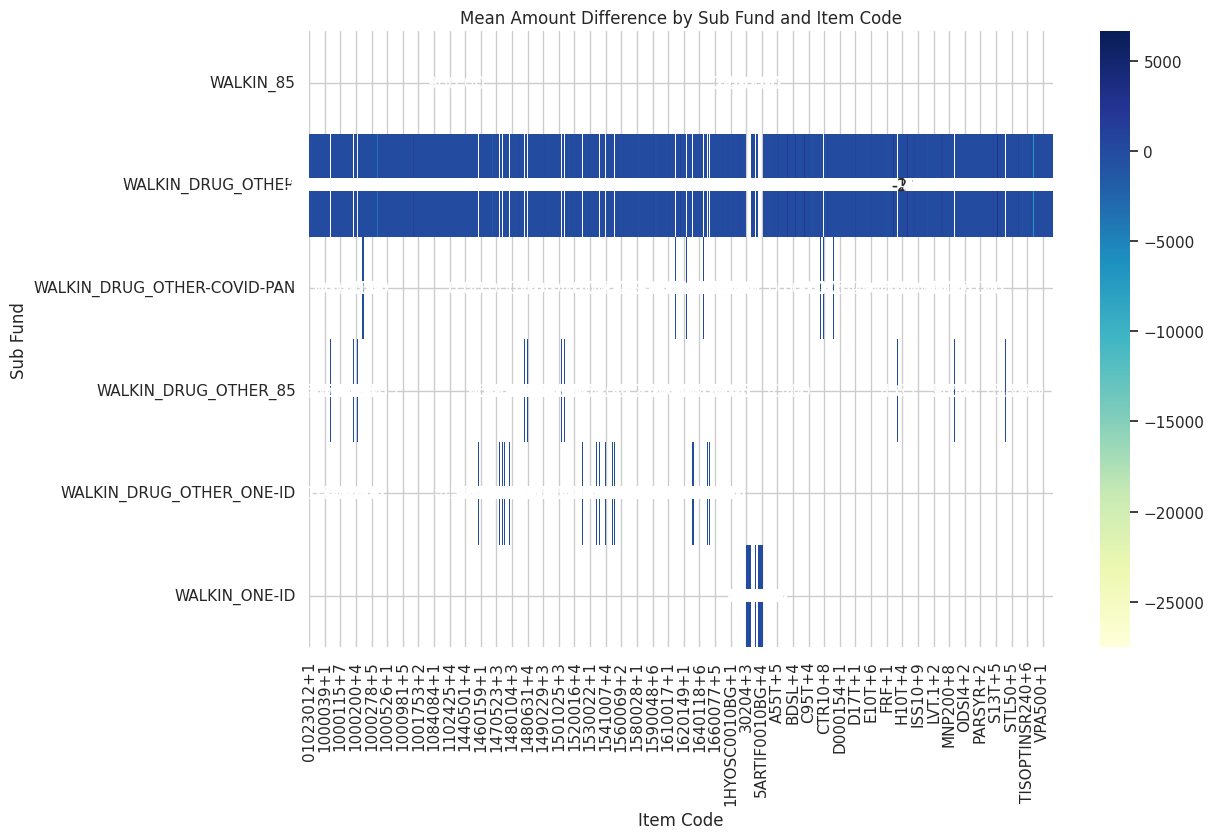

In [ ]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Visualization 2: Boxplot to show the distribution of 'amt_diff' and 'ratio' across different 'sub_fund'
plt.figure(figsize=(12, 6))
sns.boxplot(data=subfund_analysis, x='sub_fund', y='amt_diff', palette='Set2')
plt.xticks(rotation=90)
plt.title('Distribution of Amount Difference (amt_diff) by sub_fund')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=subfund_analysis, x='sub_fund', y='ratio', palette='Set2')
plt.xticks(rotation=90)
plt.title('Distribution of Ratio by sub_fund')
plt.show()

# Visualization 5: Heatmap of aggregated metrics (mean) for each combination of 'sub_fund', 'hcode', and 'item_code'
pivot = grouped_analysis.pivot_table(values='mean_amt_diff', index='sub_fund', columns='item_code', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Mean Amount Difference by Sub Fund and Item Code')
plt.ylabel('Sub Fund')
plt.xlabel('Item Code')
plt.show()


# distribution of act amt by subfund ****